# Parse Json

In [1]:
def parseRaw(json_map):
    url = json_map['url']
    content = json_map['html']
    return (url,content)

# 載入原始 RAW Data

In [2]:
import json
import pprint
pp = pprint.PrettyPrinter(indent=2)
path = "./pixnet.txt"
all_content = sc.textFile(path).map(json.loads).map(parseRaw)

# 使用 BeautifulSoup 及 Jieba 來處理文章內容

### BeautifulSoup 
- [Official Doc](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- BeautifulSoup 是一個常用來 parsing HTML 或是 XML 文件的強大工具，只要把標準格式的資料以字串型態帶入，就能夠以物件屬性的方式操作文件裡各個區塊。(ex. soup.title.name, soup.p, soup.b.attrs, soup.p['class'], ...)  
- 實用涵式
    - soup.find_all('a'): get a list
    - soup.{element}.get_text(): get a string
    - soup.{element}.get('href'): get a string
    - soup.{element}.contents: get element's childrens in a list
        - soup.{element}.contents[0].name
    - soup.descendants: let user iterate over all of a tag’s children
    - soup.prettify(): show document in the format frendly to viewer
    
### Jieba
- [Official Doc](https://github.com/fxsjy/jieba/blob/master/README.md)
- [FUKUBALL Blog](http://blog.fukuball.com/ru-he-shi-yong-jieba-jie-ba-zhong-wen-fen-ci-cheng-shi/)
- Jieba 是知名的 open source 中文斷詞系統，default 為簡體語系，但能支援設定繁體語庫或是自定義語庫(ex. 自建台語語庫)。支援的功能有：基本斷詞、詞性判斷、TF-IDF文章關鍵字萃取。
- 實用涵式
    - jieba.cut(sentence, cut_all=False): 基本斷詞
        - False(精确模式): 對內文做最精確的分析
        - True(全模式): 把所有可能的斷詞都列出來
    - jieba.cut_for_search(sentence）: 搜索引擎模式
        - 以精確模式為基礎，對長詞再次切分，提高recall比例，適合搜尋相關應用。
    - jieba.set_dictionary('dict.txt'): 指定語庫
    - jieba.posseg.cut(): 取出斷詞及詞性 (回傳值具有 word 及 flag 屬性，flag 極為詞性)
    - jieba.analyse.extract_tags(sentence, tag_num): 文章提取關鍵字

In [3]:
def getContent(x):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(x)
    text = soup.getText().replace('\n','').replace('\r','').replace(' ','').replace('\t','')
    import jieba
    r = list()
    

    for term in jieba.cut(text):
        if len(term) > 1 and checkword(term): r.append(term)
    return r
def checkword(x):
    return all(u'\u4e00' <= c <= u'\u9fff' for c in x)

# 印出第一筆資料

In [4]:
parsed = all_content.mapValues(lambda x : getContent(x))
print 'url:',parsed.first()[0]
print 'term:',
for term in parsed.first()[1][:10] :
    print term , 

url: http://chahabi77.pixnet.net/blog/post/436715527
term: 阪神 新手 必看 大阪 京都 神戶 自由 行總 行程 行程


# 請完成以下程碼來計算 Global 詞頻，並取出前 10 個最常出現的詞

In [5]:
for i in parsed.map(lambda x: x[1]).flatMap(lambda x : x).take(10):
    print i

阪神
新手
必看
大阪
京都
神戶
自由
行總
行程
行程


#依照詞頻由高到低取出前 10 

In [6]:
from operator import add
top_term = parsed.map(
    lambda x: x[1]).flatMap(
    lambda x : x).map(
    lambda x: (x,1)).reduceByKey(
    add).sortBy(
    lambda x: x[1],ascending=False)
for term in top_term.take(10):
    print term[0] , term[1]

大阪 428
美食 427
日本 319
澳門 198
韓國 195
自由 191
京都 176
機場 168
東京 160
行程 156


# 產生 WordCloud

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

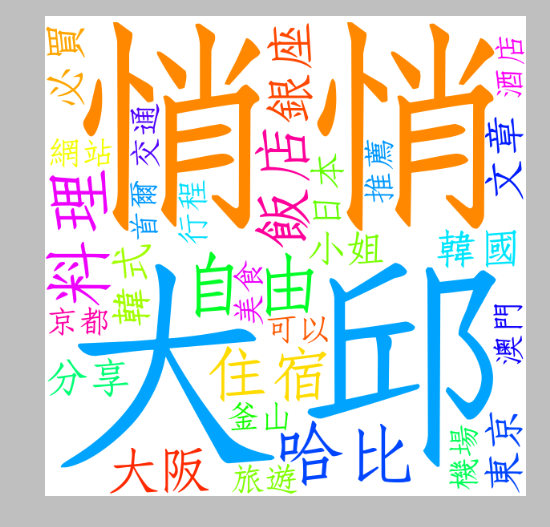

In [8]:
no_urls_no_tags  = " ".join(top_term.map(lambda x : x[0]).take(30))
wordcloud = WordCloud(
                      font_path='./cwTeXQFangsong-Medium.ttf',
                      background_color='white',
                      width=600,
                      height=600
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#考題 : 反向由小到大，取出最小的40個字，並畫出 WordCloud

In [10]:
top_term2 = parsed.map(
    lambda x: x[1]).flatMap(
    lambda x : x).map(
    lambda x: (x,1)).reduceByKey(
    add).sortBy(
    lambda x: x[1],ascending=True)

In [11]:
top_term2.first()

(u'\u661f\u671f\u4e09', 1)

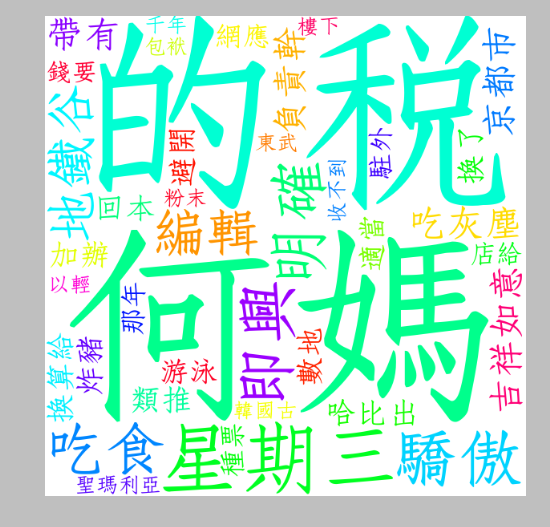

In [12]:
no_urls_no_tags  = " ".join(top_term2.map(lambda x : x[0]).take(40))
wordcloud = WordCloud(
                      font_path='./cwTeXQFangsong-Medium.ttf',
                      background_color='white',
                      width=600,
                      height=600
                     ).generate(no_urls_no_tags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()